# dp100_20 機械学習モデルを説明する

モデルによる予測に影響を与える要員を理解できることがますます重要になっている。

## 特徴の重要性

モデルの**Explainer**は、*特徴量の重要度*を計算するために統計的技法を使用する。  
これにより、トレーニングデータセットの各特徴量がラベル予測に与える相対的な影響を定量化できる。
Explainerは、特徴量ケースのテストデータセットと、モデルで予測されるラベルを評価することによって機能する。

### グローバル特徴量の重要度

グローバル特徴量の重要度は、テストデータセット全体における各特徴量の相対的な重要度を定量化する。  
これにより、データセット内の各特徴量が予測に影響を与える程度の一般的な比較が提供される。

### ローカル特徴量の重要度

ローカル特徴量の重要度では、個別の特定の予測に対する各特徴量の値の影響が測定される。

## Explainerを使用する

AzureML実験でトレーニングされていないモデルに対しても、SDKを使用してExplainerを作成できる。

### Explainerを作成する

ローカルモデルを解釈するには**azureml-interpret**パッケージをインストールし、それを使用してExplainerを作成する必要がある。  
Explainerには以下のような複数の種類がある。

- **MinicExplainer**

    - トレーニング済みのモデルの近似値を求め、説明を生成するために使用できる"グローバルサロゲートモデル"を作成するためのExplainer。  
    この説明可能なモデルには、トレーニング済みのモデルと同じ種類のアーキテクチャが必要(例えば線形またはツリーベース)

- **TabularExplainer**

    - さまざまなSHAP Explainerアルゴリズムのラッパーとして機能し、モデルアーキテクチャに最適なものを自動的に選択するためのExplainer。  

- **PFIExplainer**

    - 特徴量の値をシャッフルし、予測パフォーマンスへの影響を測定することにより、特徴量の重要度を分析するための"順列特徴量の重要度"Explainer.

次のコード例は、**loan_model**という架空モデルに対して、これらの各種類のExplainerのインスタンスを作成する方法を示す。

```
# MimicExplainer
from interpret.ext.blackbox import MimicExplainer
from interpret.ext.glassbox import DecisionTreeExplainableModel

mim_explainer = MimicExplainer(model=loan_model,
                             initialization_examples=X_test,
                             explainable_model = DecisionTreeExplainableModel,
                             features=['loan_amount','income','age','marital_status'], 
                             classes=['reject', 'approve'])
                             

# TabularExplainer
from interpret.ext.blackbox import TabularExplainer

tab_explainer = TabularExplainer(model=loan_model,
                             initialization_examples=X_test,
                             features=['loan_amount','income','age','marital_status'],
                             classes=['reject', 'approve'])


# PFIExplainer
from interpret.ext.blackbox import PFIExplainer

pfi_explainer = PFIExplainer(model = loan_model,
                             features=['loan_amount','income','age','marital_status'],
                             classes=['reject', 'approve'])
```

### グローバル特徴量の重要度を説明する

お使いのモデルにおける特徴量のグローバル重要度の値を説明するには、Explainerの**explain_global()**メソッドを呼び出し、  
グローバルの説明を取得した後**get_feature_importance_dict()**メソッドを使用して特徴量の重要度の値の辞書配列を取得。

```
# MimicExplainer
global_mim_explanation = mim_explainer.explain_global(X_train)
global_mim_feature_importance = global_mim_explanation.get_feature_importance_dict()


# TabularExplainer
global_tab_explanation = tab_explainer.explain_global(X_train)
global_tab_feature_importance = global_tab_explanation.get_feature_importance_dict()


# PFIExplainer
global_pfi_explanation = pfi_explainer.explain_global(X_train, y_train)
global_pfi_feature_importance = global_pfi_explanation.get_feature_importance_dict()
```

> 注 : コードは**MinicExplainer**と**TabularExplainer**で同じになる。  
**PFIExplainer**には、テストの特徴量に対応する実際のラベルが必要。

### ローカル特徴量の重要度を説明する

**MinicExplainer**または**TabularExplainer**からローカル特徴量の重要度を取得するには、  
説明するケースのサブセットを指定して、Explainerの**explain_local()**メソッドを呼び出す。  
その後、**get_ranked_local_names()**と**get_ranked_local_values()**の各メソッドを使用して、  
特徴量の名前と重要度の値の辞書配列を重要度順に取得できる。

```
# MimicExplainer
local_mim_explanation = mim_explainer.explain_local(X_test[0:5])
local_mim_features = local_mim_explanation.get_ranked_local_names()
local_mim_importance = local_mim_explanation.get_ranked_local_values()


# TabularExplainer
local_tab_explanation = tab_explainer.explain_local(X_test[0:5])
local_tab_features = local_tab_explanation.get_ranked_local_names()
local_tab_importance = local_tab_explanation.get_ranked_local_values()
```

> 注 : コードは**MinicExplainer**と**TabularExplainer**でおなじになる。  
**PFIExplainer**では、ローカル特徴量の重要度の説明はサポートされていない。

## 説明を作成する

作成したExplainerによって生成される説明を実行にアップロードしてあとで分析できる。

### 実験スクリプトで説明を作成する

実験スクリプトで説明を作成するには、実行環境に**azureml-interpret**と**azureml-contrib-interpret**の両方のパッケージが必要。  
これらを使用して、トレーニング済みモデルから説明を作成し、その説明を実行出力にアップロードすることができる。

次のコード例は、モデルの説明を生成してアップロードするコードを実験スクリプトに組み込む方法を示している。

```
# Import Azure ML run library
from azureml.core.run import Run
from azureml.contrib.interpret.explanation.explanation_client import ExplanationClient
from interpret.ext.blackbox import TabularExplainer
# other imports as required

# Get the experiment run context
run = Run.get_context()

# code to train model goes here

# Get explanation
explainer = TabularExplainer(model, X_train, features=features, classes=labels)
explanation = explainer.explain_global(X_test)

# Get an Explanation Client and upload the explanation
explain_client = ExplanationClient.from_run(run)
explain_client.upload_model_explanation(explanation, comment='Tabular Explanation')

# Complete the run
run.complete()
```

### 説明を表示する

モデルに対して作成した説明は、AzureMLスタジオの実行の**説明**タブで確認できる。  
**ExplanationClient**オブジェクトを使用して、Pythonで説明をダウンロードすることもできる。

```
from azureml.contrib.interpret.explanation.explanation_client import ExplanationClient

client = ExplanationClient.from_run_id(workspace=ws,
                                       experiment_name=experiment.experiment_name, 
                                       run_id=run.id)
explanation = client.download_model_explanation()
feature_importances = explanation.get_feature_importance_dict()
```

## 説明を視覚化する

AzureMLスタジオのモデルの説明には、特徴量の重要度を調べるために使用できる複数の視覚化が含まれている。

> 注 : 視覚化は、説明を生成してアップロードするように構成された実験の実行にのみ使用できる。  
自動機械学習を使用する場合、規定では最適なモデルを生成する実行のみ説明が生成される。

### グローバル特徴量の重要度を視覚化する

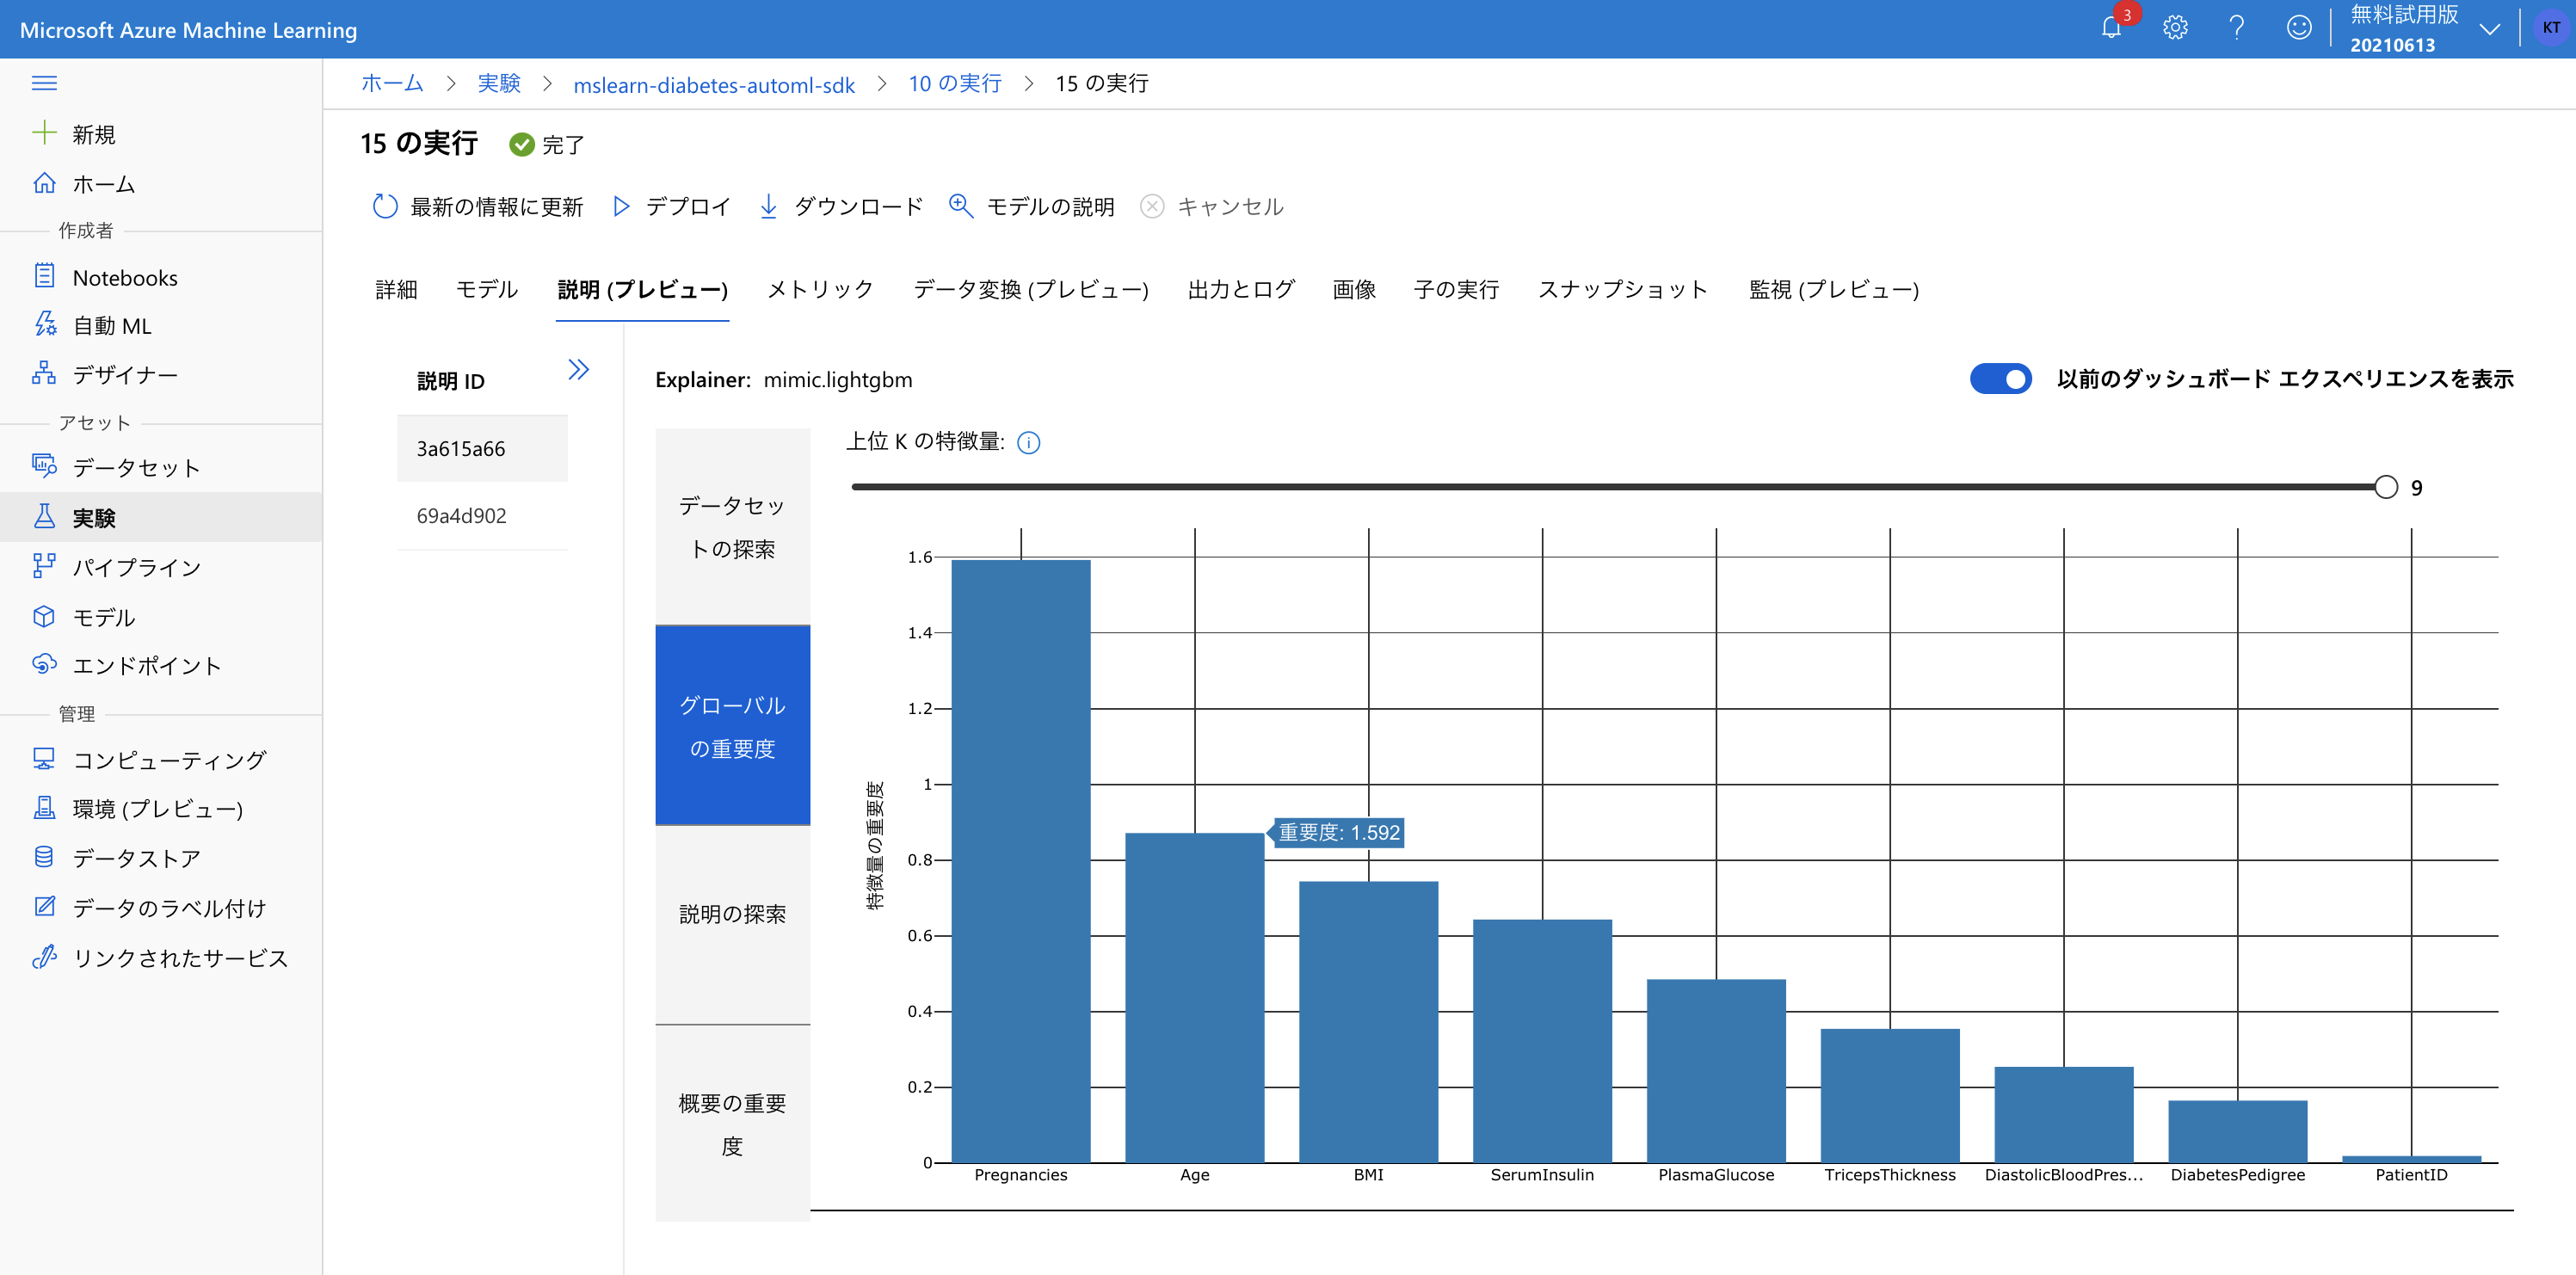

### 概要の重要度を視覚化する

テストデータセット全体における各特徴量の個別の重要度の値の分布が表示される。

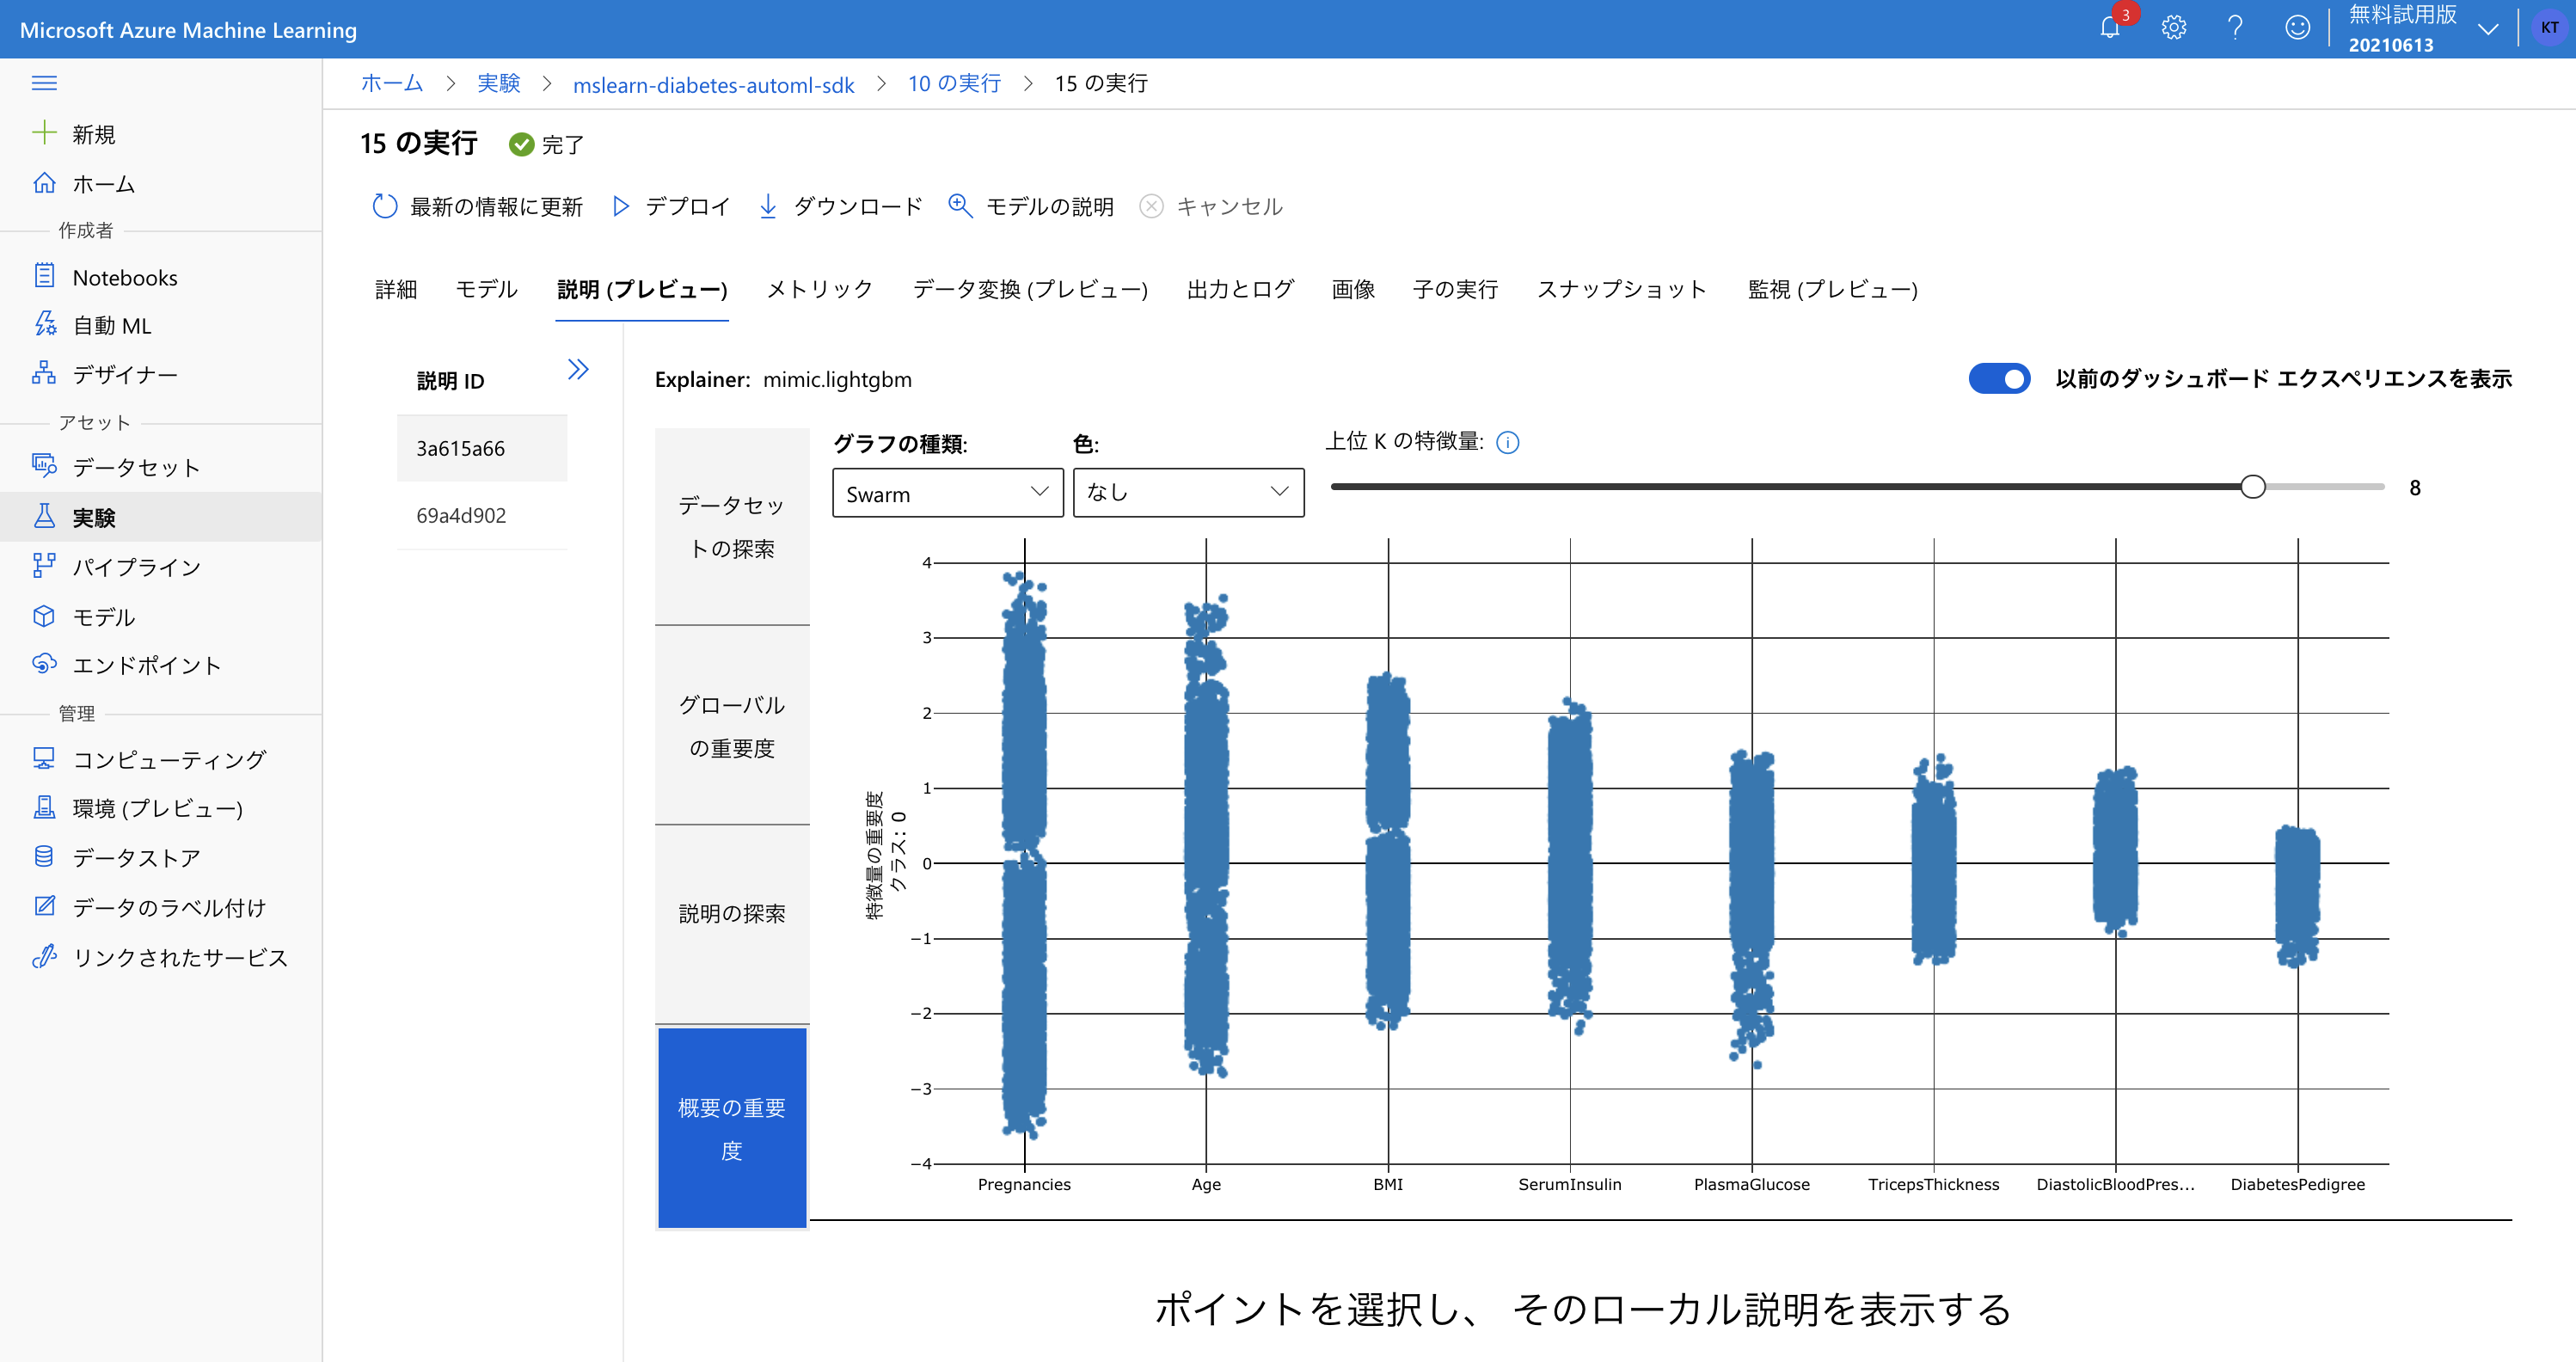

### ローカル特徴量の重要度を視覚化する

個別のデータポイントを選択すると、データポイントが属するケースのローカル特徴量の重要度が表示される。

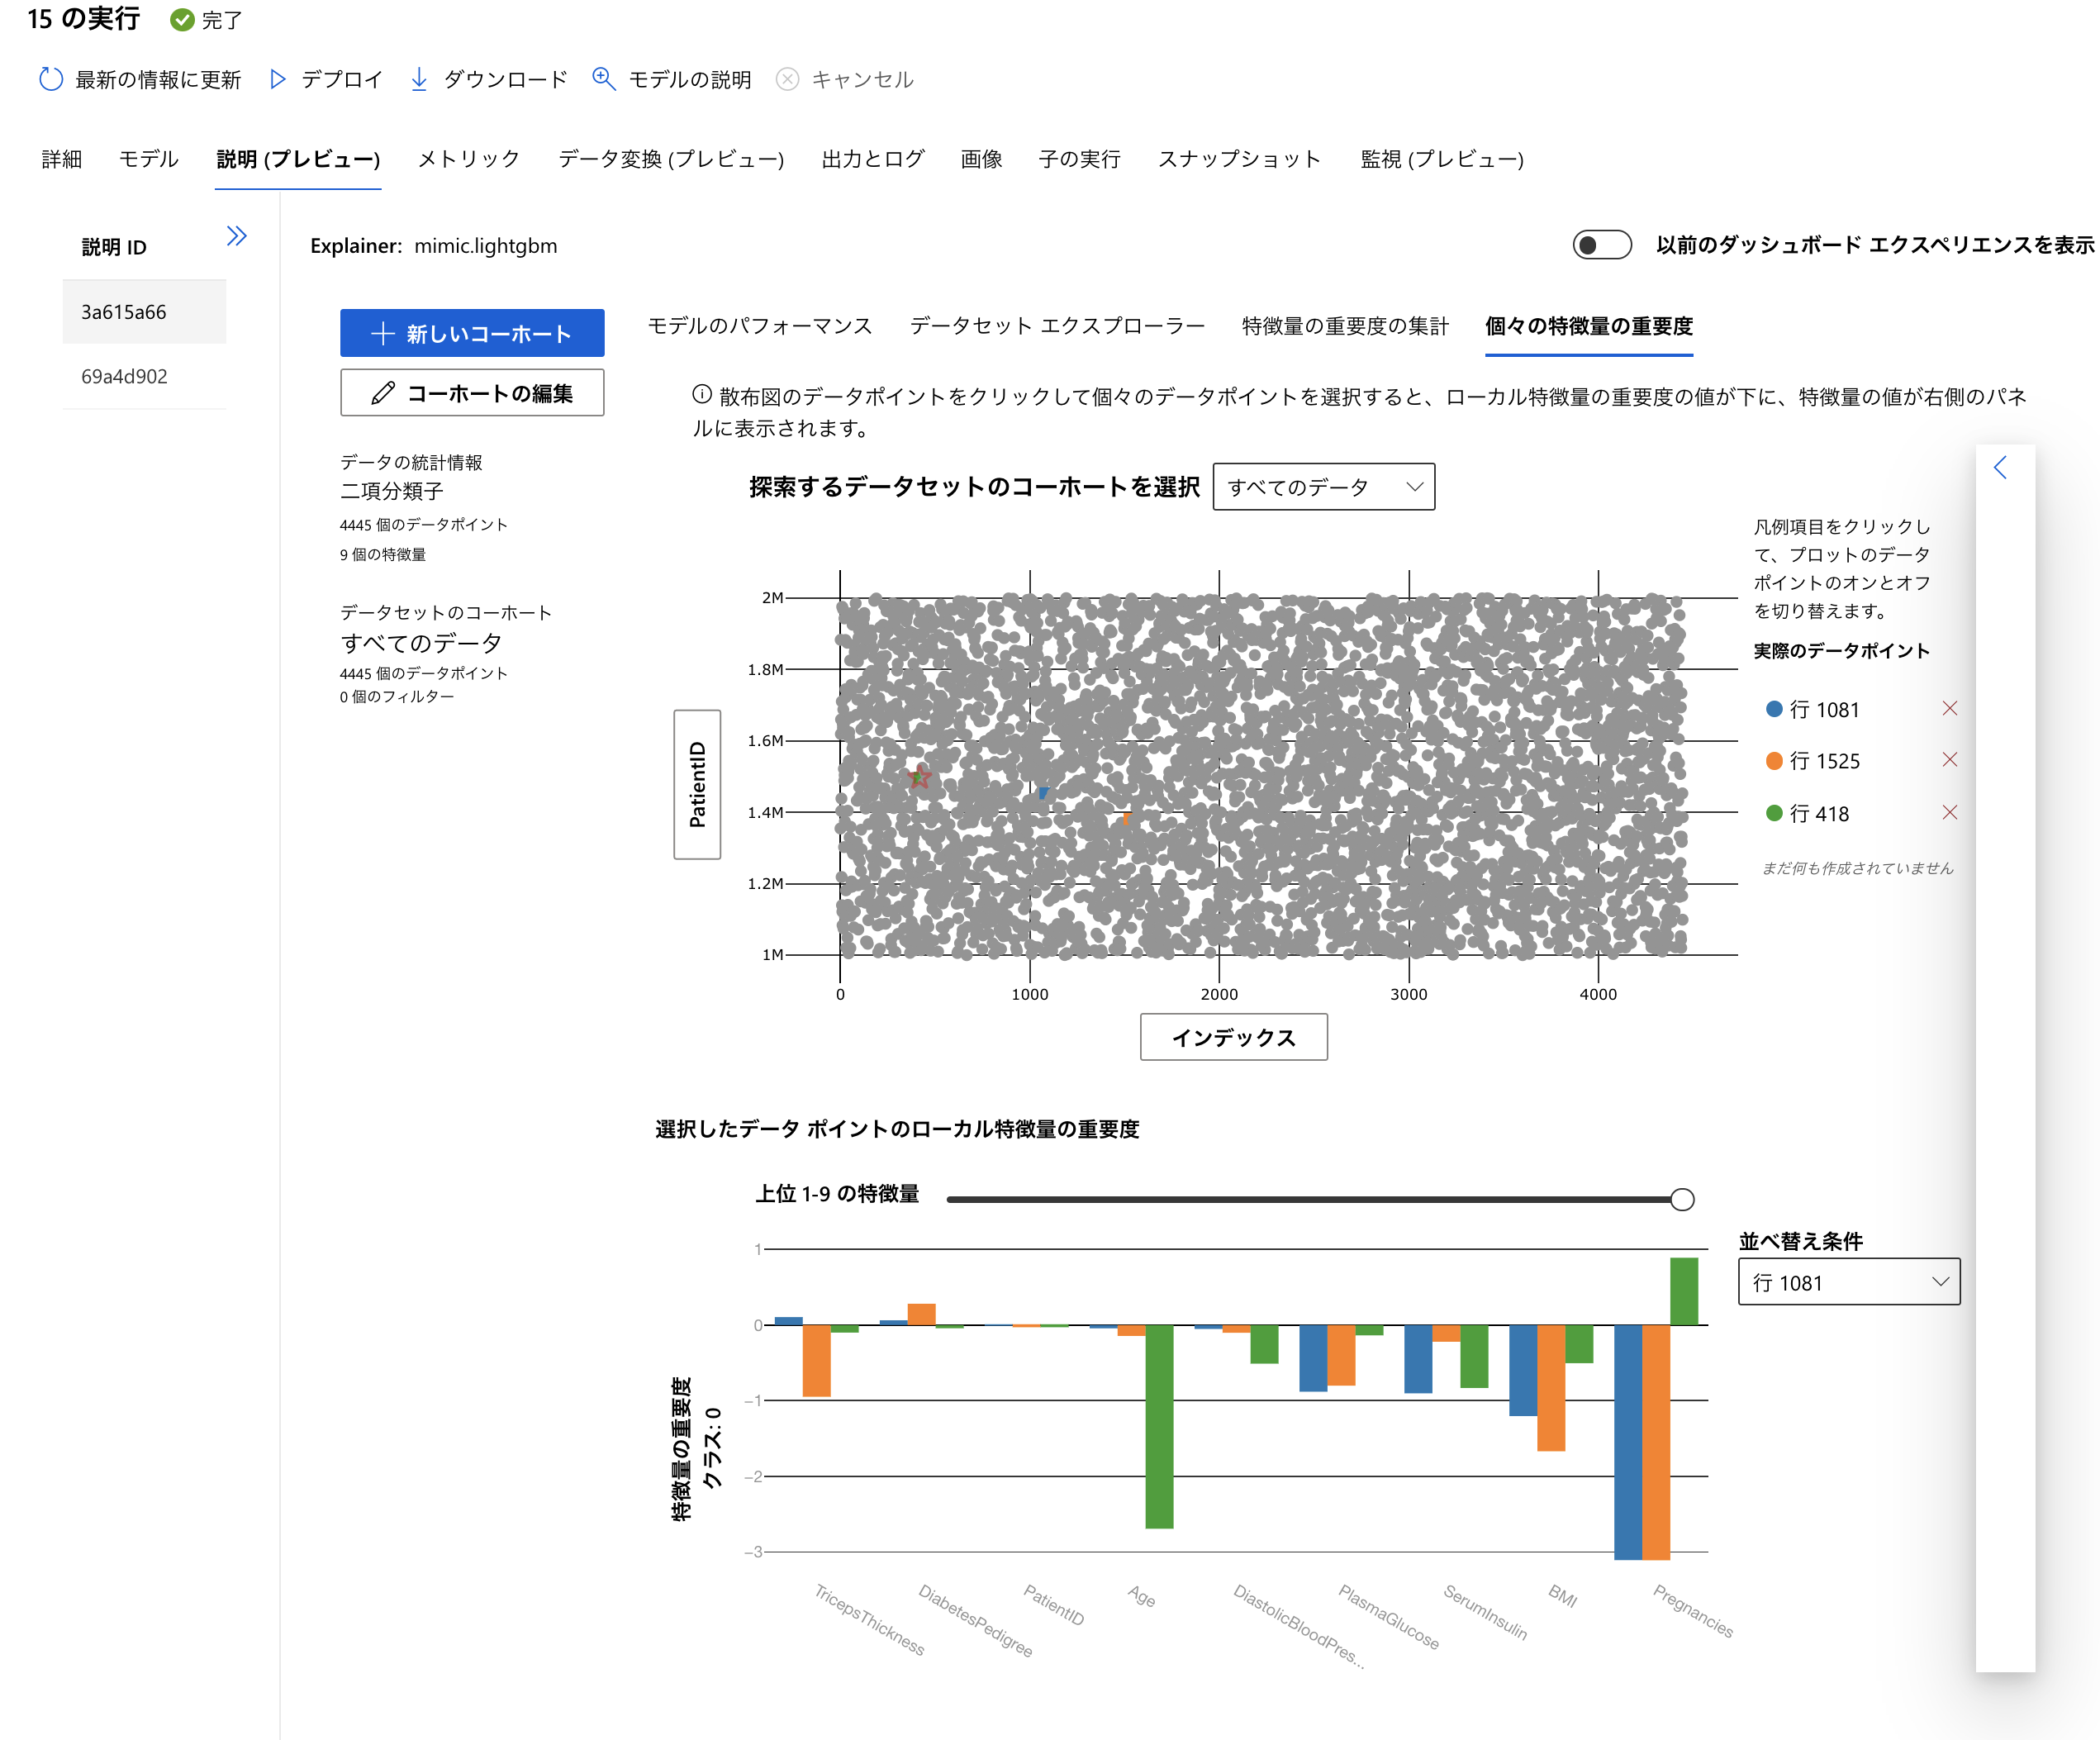

## 演習 モデルの解釈

### SDKパッケージのインストール

以下のパッケージを使うと、AzureML実験でトレーニングされていなくても、Azure MLワークスペースに登録されていなくても、  
多くの典型的な種類のモデルを解釈することができる。

In [1]:
!pip show azureml-explain-model azureml-interpret

Name: azureml-explain-model
Version: 1.28.0
Summary: Machine Learning explain model package is used to interpret ML models
Home-page: https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py
Author: Microsoft Corp
Author-email: None
License: https://aka.ms/azureml-sdk-license
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: azureml-interpret
Required-by: 
---
Name: azureml-interpret
Version: 1.28.0
Summary: Machine Learning interpret package is used to interpret ML models
Home-page: https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py
Author: Microsoft Corp
Author-email: None
License: https://aka.ms/azureml-sdk-license
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: interpret-community, interpret-core, azureml-core
Required-by: azureml-train-automl-runtime, azureml-explain-model


### モデルを説明する

まずはAzureMLの外でトレーニングされたモデルから説明する。  
以下のセルを実行して、決定木の分類モデルをトレーニングする。

In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# load the diabetes dataset
print("Loading Data...")
data = pd.read_csv('data/diabetes.csv')

# Separate features and labels
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
labels = ['not-diabetic', 'diabetic']
X, y = data[features].values, data['Diabetic'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train a decision tree model
print('Training a decision tree model')
model = DecisionTreeClassifier().fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

print('Model trained.')

Loading Data...
Training a decision tree model
Accuracy: 0.8926666666666667
AUC: 0.879600975172894
Model trained.


#### モデルのexplainerを用意する

モデルに適したexplainerを入手する。さまざまな種類があり、この例では*Tabular Explainer*を用いるが、  
これはブラックボックスのようなexplainerであり、適切なSHAPモデルのexplainerを呼び出すことで様々な種類のモデルを説明することができる。

In [3]:
from interpret.ext.blackbox import TabularExplainer

# "features" and "classes" fields are optional
tab_explainer = TabularExplainer(model,
                             X_train, 
                             features=features, 
                             classes=labels)
print(tab_explainer, "ready!")

TabularExplainer ready!


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


#### 全体的な特徴の重要性を取得

まず最初にグローバル特徴量の重要性を評価することで、モデルを説明しようとする。  
言い換えれば、トレーニングデータセット全体に基づいて、各特徴が予測にどの程度影響を与えるかを定量化する。

In [4]:
# you can use the training data or the test data here
global_tab_explanation = tab_explainer.explain_global(X_train)

# Get the top features by importance
global_tab_feature_importance = global_tab_explanation.get_feature_importance_dict()
for feature, importance in global_tab_feature_importance.items():
    print(feature,":", importance)

Pregnancies : 0.21901222022996678
Age : 0.10676823317489358
BMI : 0.09218418284216827
SerumInsulin : 0.06837405742328476
PlasmaGlucose : 0.04915980174341492
TricepsThickness : 0.022345814550257623
DiastolicBloodPressure : 0.016311181511403157
DiabetesPedigree : 0.01379223948070996


特徴量の重要度はランク付けされ、最も重要な特徴量が先頭に表示される。

#### ローカル特徴量の重要度を取得

全体像は把握できたが、個々の観測結果の説明についてはどうか？  
個々の予測に対する局所的な説明を生成し、特徴量の各値になったことへの影響度合いを定量化してみる。  
このケースでは、バイナリモデルなので、2つの可能なラベル(non-diabeticとdiabetic)がある。  
そしてデータセット内の個々の観測について、これらのラベル値のそれぞれに対する各特徴量の影響を定量化できる。

ここではテストデータセットの最初の2つのケースを評価する。

In [5]:
# Get the observations we want to explain (the first two)
X_explain = X_test[0:2]

# Get predictions
predictions = model.predict(X_explain)

# Get local explanations
local_tab_explanation = tab_explainer.explain_local(X_explain)

# Get feature names and importance for each possible label
local_tab_features = local_tab_explanation.get_ranked_local_names()
local_tab_importance = local_tab_explanation.get_ranked_local_values()

for l in range(len(local_tab_features)):
    print('Support for', labels[l])
    label = local_tab_features[l]
    for o in range(len(label)):
        print("\tObservation", o + 1)
        feature_list = label[o]
        total_support = 0
        for f in range(len(feature_list)):
            print("\t\t", feature_list[f], ':', local_tab_importance[l][o][f])
            total_support += local_tab_importance[l][o][f]
        print("\t\t ----------\n\t\t Total:", total_support, "Prediction:", labels[predictions[o]])

Support for not-diabetic
	Observation 1
		 SerumInsulin : 0.36672383960054783
		 Age : 0.24020487255589434
		 TricepsThickness : 0.025114657461624543
		 BMI : 0.014724142498088667
		 DiabetesPedigree : 0.00285689920287805
		 DiastolicBloodPressure : -0.017643118107843383
		 PlasmaGlucose : -0.03213399668009788
		 Pregnancies : -0.26641872510252135
		 ----------
		 Total: 0.3334285714285708 Prediction: not-diabetic
	Observation 2
		 BMI : 0.350309895732718
		 DiabetesPedigree : 0.0376048520927328
		 Pregnancies : 0.0152425193406744
		 PlasmaGlucose : 0.008023975423712651
		 Age : 0.007982468116917576
		 DiastolicBloodPressure : -0.010084325648018113
		 TricepsThickness : -0.019007735654833664
		 SerumInsulin : -0.05664307797533264
		 ----------
		 Total: 0.33342857142857096 Prediction: not-diabetic
Support for diabetic
	Observation 1
		 Pregnancies : 0.2664187251025209
		 PlasmaGlucose : 0.032133996680097955
		 DiastolicBloodPressure : 0.017643118107843404
		 DiabetesPedigree : -0.00285

### モデルトレーニング実験に説明を付与する

実験を使ってAzureMLのワークスペースでモデルを訓練・登録する際には、モデルの説明を生成してログを取ることができる。

次のセルのコードを実行してワークスペースに接続する。

In [8]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.28.0 to work with 20210613


#### 実験によるモデルの学習と説明

In [9]:
import os, shutil
from azureml.core import Experiment

# Create a folder for the experiment files
experiment_folder = 'diabetes_train_and_explain'
os.makedirs(experiment_folder, exist_ok=True)

# Copy the data file into the experiment folder
shutil.copy('data/diabetes.csv', os.path.join(experiment_folder, "diabetes.csv"))

'diabetes_train_and_explain/diabetes.csv'

In [10]:
%%writefile $experiment_folder/diabetes_training.py
# Import libraries
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Import Azure ML run library
from azureml.core.run import Run

# Import libraries for model explanation
from azureml.interpret import ExplanationClient
from interpret.ext.blackbox import TabularExplainer

# Get the experiment run context
run = Run.get_context()

# load the diabetes dataset
print("Loading Data...")
data = pd.read_csv('diabetes.csv')

features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
labels = ['not-diabetic', 'diabetic']

# Separate features and labels
X, y = data[features].values, data['Diabetic'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train a decision tree model
print('Training a decision tree model')
model = DecisionTreeClassifier().fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
run.log('Accuracy', np.float(acc))

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
run.log('AUC', np.float(auc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename='outputs/diabetes.pkl')

# Get explanation
explainer = TabularExplainer(model, X_train, features=features, classes=labels)
explanation = explainer.explain_global(X_test)

# Get an Explanation Client and upload the explanation
explain_client = ExplanationClient.from_run(run)
explain_client.upload_model_explanation(explanation, comment='Tabular Explanation')

# Complete the run
run.complete()

Writing diabetes_train_and_explain/diabetes_training.py


In [11]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails


# Create a Python environment for the experiment
explain_env = Environment("explain-env")

# Create a set of package dependencies (including the azureml-interpret package)
packages = CondaDependencies.create(conda_packages=['scikit-learn','pandas','pip'],
                                    pip_packages=['azureml-defaults','azureml-interpret'])
explain_env.python.conda_dependencies = packages

# Create a script config
script_config = ScriptRunConfig(source_directory=experiment_folder,
                      script='diabetes_training.py',
                      environment=explain_env) 

# submit the experiment
experiment_name = 'mslearn-diabetes-explain'
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-diabetes-explain_1623827022_6c5665ae',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-06-16T07:05:14.712943Z',
 'endTimeUtc': '2021-06-16T07:05:21.8747Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '05d5b545-2452-4847-ba52-1fc81d870921',
  'azureml.git.repository_uri': 'https://github.com/iguru0331/mslearn-dp100.git',
  'mlflow.source.git.repoURL': 'https://github.com/iguru0331/mslearn-dp100.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': 'ed510154034e8c2bf830bb52bd28e078b6c98d13',
  'mlflow.source.git.commit': 'ed510154034e8c2bf830bb52bd28e078b6c98d13',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_training.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataRefe

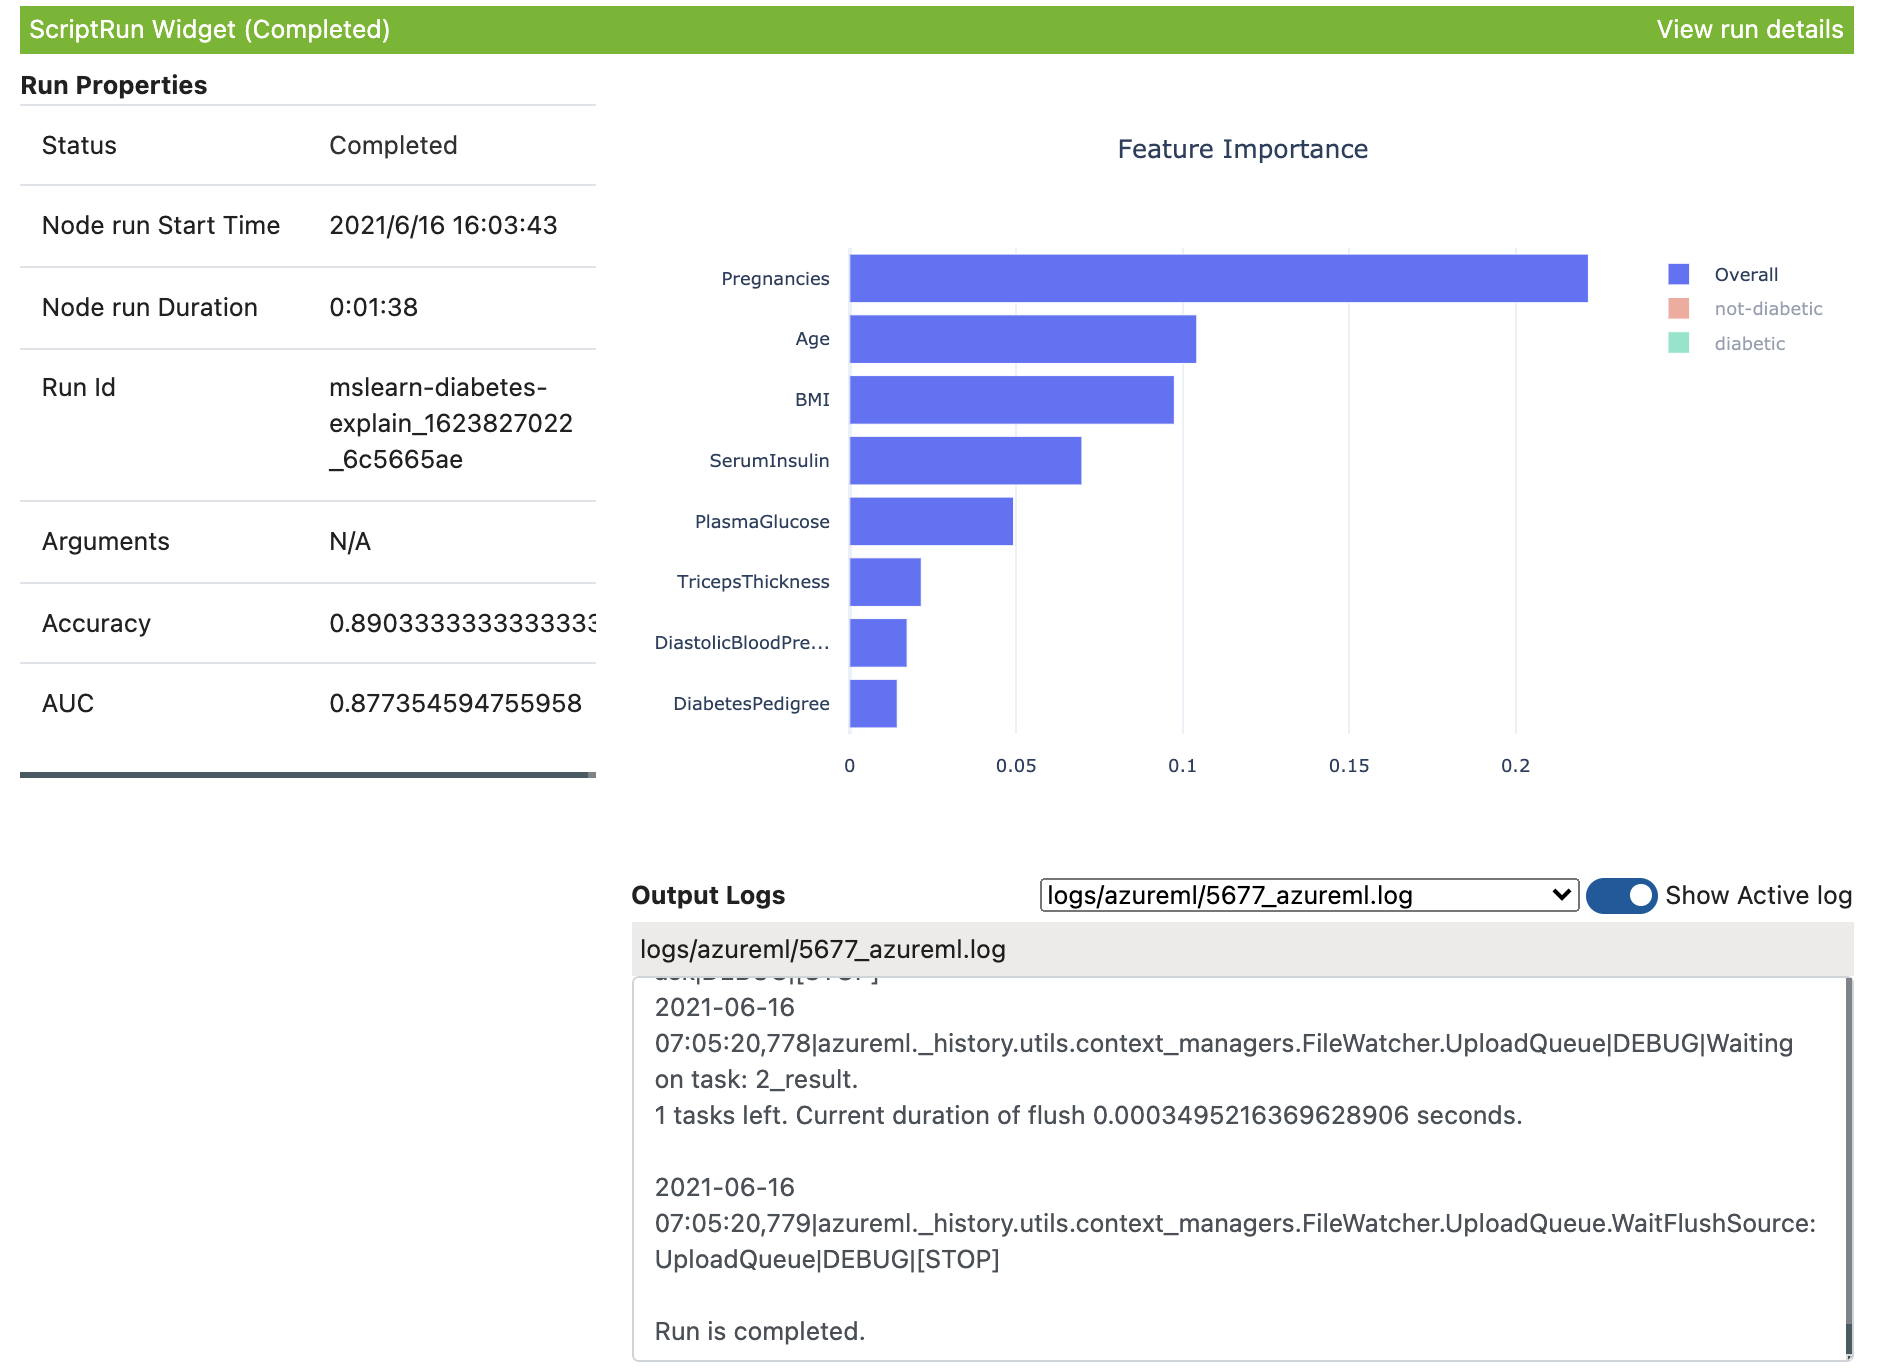

### 特徴量の重要度の値を取得する

実験の実行が完了したら、**ExplanationClient**クラスを使用して、実行時に登録された説明文から特徴量の重要度を取得することができる。

In [12]:
from azureml.interpret import ExplanationClient

# Get the feature explanations
client = ExplanationClient.from_run(run)
engineered_explanations = client.download_model_explanation()
feature_importances = engineered_explanations.get_feature_importance_dict()

# Overall feature importance
print('Feature\tImportance')
for key, value in feature_importances.items():
    print(key, '\t', value)

Feature	Importance
Pregnancies 	 0.2218630967007607
Age 	 0.10423382017695933
BMI 	 0.09748690841921315
SerumInsulin 	 0.0697320978103293
PlasmaGlucose 	 0.04920419444739837
TricepsThickness 	 0.021474304545360843
DiastolicBloodPressure 	 0.017225710582080757
DiabetesPedigree 	 0.014248697808116582


### AzureMLスタジオで説明をみる

AzureMLスタジオで**実行**を確認し、**説明**タブを表示することもできる。

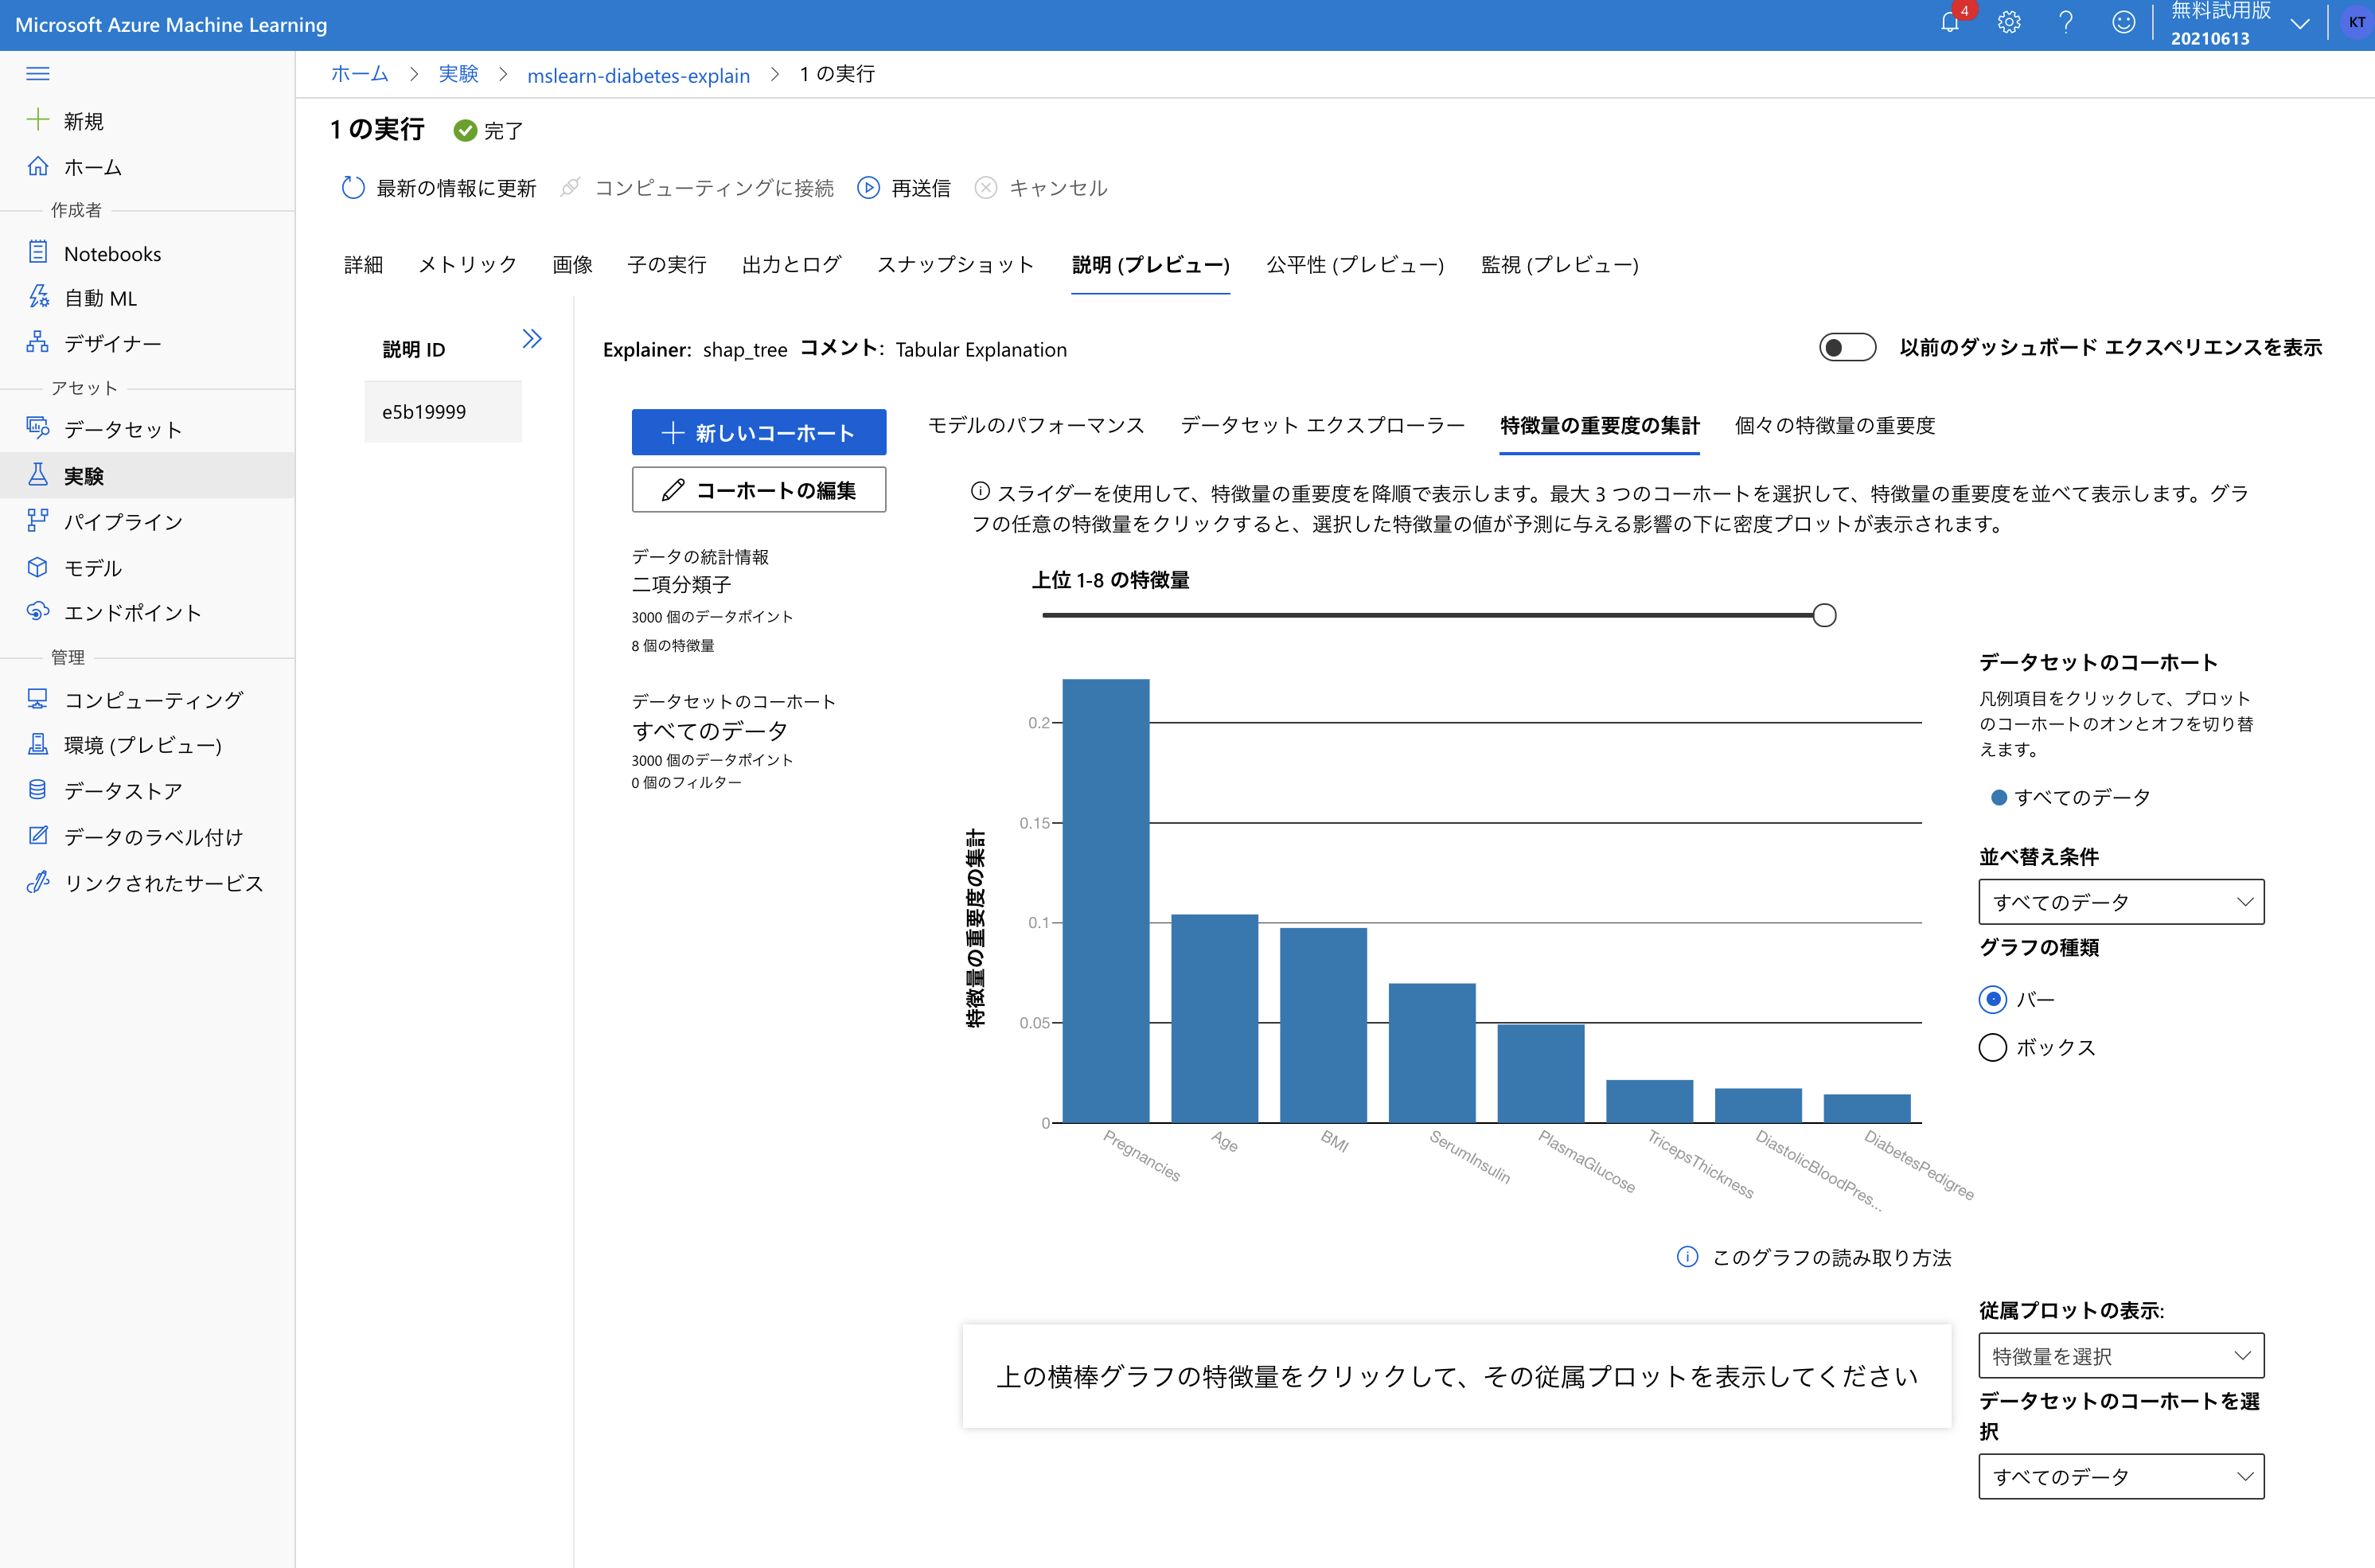

> AzureMLの説明の詳細URL : https://docs.microsoft.com/azure/machine-learning/how-to-machine-learning-interpretability

## 知識チェック

1. 分類モデルのトレーニングが完了し、特定の個別の予測に対する各特徴量の影響を定量化するとします。 何を調べる必要がありますか?

    - グローバル特徴量の重要度
    - ローカル特徴量の重要度
    - 再現率と精度

2. アーキテクチャに適した SHAP アルゴリズムを使用してモデルを解釈するのはどの Explainer ですか?

    - PFIExplainer
    - MimicExplainer
    - TabularExplainer

↓解答

1. ローカル特徴量の重要度

    - ローカルの重要度は、特定の予測に対する特徴量の影響を示します。 グローバルの重要度は、全体的な特徴量の影響を示します。

2. TabularExplainer

    - TabularExplainer は、さまざまな SHAP Explainer アルゴリズムのラッパーとして機能し、モデル アーキテクチャに最適なものが自動的に選択されます。